In [1]:
# Pick convention: 
# We work on a rectangular cell of side lengths a, b, c
# This cuboid is in the positive coordinates and centered at 0
# I.e. spanned by (a,0,0), (0,b,0) and (0,0,c)

# Loading Packages

In [1]:
import numpy as np
import numpy.linalg as la
import random as rd
import gudhi as gd
import Simplex_Classes_3D as sc

# Generating random points (optional)

This function generates $N$ random points in a cell of sidelenghts $a,b,c$.  
This is for demonstration and testing, but not an integral part of the software.

In [2]:
def gen_points(N=5,a=1,b=1,c=1):
    """
    Generates N random points in [0,a]x[0,b]x[0,c] cuboid,
    outputts Nx3 numpy array, each row containing x, y,z coordinates of a point.
    """
    return np.array([[rd.random()*a,rd.random()*b,rd.random()*c] for i in range(N)])


# Creating periodic $\alpha$-filtration

## Auxiliary functions for periodic_filtration()

### Duplicating points to neighbouring cells
Given points in a unit cell, this function duplicates them by translating to all neighbouring cells.  
This is an auxiliary step to calculating the _periodic_ $\alpha$-filtration. 

In [3]:
def torus_copy(points, a=1,b=1,c=1):
    """
    Takes numpy array points of N points on axbxc cube
    and creates 8 copies surrounding it.
    
    Returns new_points, containing original points and 9+8+9=26 offset copies,
    so Nx27 points in total.
    """
    
    N = np.shape(points)[0]
    # first index  = which axbxc cuboid we are working on
    # second index = index of corresponding original point
    # third index  = x, y, z coordinates of point
    new_points = np.zeros((27,N,3)) 

    i = 0 # to index the cuboid
    for x in [-a,0,a]:
        for y in [-b,0,b]:
            for z in [-c,0,c]:
                transl = np.array([[x,y,z] for dummy in range(N)])
                new_points[i,:,:] = points + transl
                i += 1
            
    return new_points.reshape(-1,3)

### Other functions

In [4]:
    def setup_unit_complex(points,max_alpha_square=float("inf"),a=1,b=1,c=1):
        """
        Setup for periodic_fitration() where the gudhi package is used
        to create an alpha filtration on the duplicated points. 
        """
        points_3x3x3 = torus_copy(points,a,b,c)
        
        # alpha-complex gets generation by gudhi
        alpha_complex = gd.AlphaComplex(points_3x3x3)
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=max_alpha_square)
        filtration = simplex_tree.get_filtration()   
        coords_cuboid = [alpha_complex.get_point(i) for i in range(len(points_3x3x3))]
        
        # SWITCH: axbxc --> 1x1x1
        coords_unit = [[x/a, y/b, z/c] for [x,y,z] in coords_cuboid]
        
        return coords_unit, filtration

In [5]:

def dim_split(filt):
    """
    Takes list of simplices 'filt' with filtration values, 
    i.e. with elements ([3,2], 0.123)
    Splits filt by dimension of elements.
    Outputs the 4 seperate lists, one for each dimension 0 to 3.
    """
    simps_split = [[] for i in range(4)]
    
    for (simp, val) in filt:
        p = len(simp)-1
        simps_split[p].append((simp,val))
        
    return simps_split[0], simps_split[1], simps_split[2], simps_split[3]

In [6]:
def check_bound(point):
    """
    Takes point with x,y,z coordinates.
    Checks if point lies in cuboid [0,1) x [0,1) x [0,1).
    If yes, outputs True, else False.
    """
    x = point[0]
    y = point[1]
    z = point[2]
    
    return (    x >= 0 and x < 1 
            and y >= 0 and y < 1 
            and z >= 0 and z < 1)

In [7]:
def equiv_num(x1,x2):
    """
    Calculates 'x1-x2 mod 1', where we always want to take 
    the representative with the smallest absolute value. 
    """
    z1 = abs((x1 - x2)%1)
    z2 = abs(z1 - 1)
    return min(z1,z2)

In [8]:
def identification_list(S0_list, S0, coords, eps = 1e-5):
    """
    Input:
        S0_list ... naive filtration list  of 0-simplices ([3],3) as given by gudhi
        S0      ... list of Simplex0D objects generated from S0

    Output:
        identify_list ... list of lists with entries [i,j], 
                           meaning that the ith vertex has to be matched to the jth Simplex0D object
    """
    # build identification list for later reference when building higher simplices
    identify_list = []
    
    """
    !
    This loop below could be made much more efficient!
    """

    for i in range(len(S0_list)):
        simp, filt_value = S0_list[i]
        coord = np.array(coords[i])

        for Simplex in S0: # looking for the point in the unit cell this corresponds to              
            other_coord = Simplex.coords

            if ((equiv_num(coord[0],other_coord[0])<eps) and 
                (equiv_num(coord[1],other_coord[1])<eps) and
                (equiv_num(coord[2],other_coord[2])<eps)):

                identify_index = Simplex.index_total

        identify_list.append([i, identify_index])
    return identify_list


In [9]:
def order_vertex(indices, coords):
    """
    Takes two vertices and outputs them by lexicographical order.
    
    Input:
        indices ... list [n0, n1], where ni is the integer filtration index of the ith vertex, identifying it uniquely 
        coords  ... list of lists [[x0, y0, z0], [x1, y1, z1]] containing the coordinates of both points.
        
    Output:
        [nl, nr]   ... list of indices in lexicographical order
        [xl,yl,zl] ... coordinates of left vertex
        [xr,yr,zl] ... coordinates of right vertex 
    
    """
    
    [n0, n1] = indices
    [x0, y0, z0] = np.around(coords[0],5)
    [x1, y1, z1] = np.around(coords[1],5)
    # we round to avoid ordering errors due to "same" being not the same
    
    
    if x0 < x1 or (x0 == x1 and y0 < y1) or (x0 == x1 and y0 == y1 and z0 < z1):
        # 0 is left
        left  = 0
        right = 1

    else:
        # 1 is left
        left  = 1
        right = 0
    
    # left vertex
    nl = indices[left]
    xl = coords[left][0]
    yl = coords[left][1]
    zl = coords[left][2]

    # right vertex
    nr = indices[right]
    xr = coords[right][0]
    yr = coords[right][1]
    zr = coords[right][2]
    return [nl, nr], [xl,yl,zl], [xr,yr,zr]

In [10]:
def crossing_vector(coord):
    """
    Takes coordinates coord=[x,y,z], which lie in unit_cube
    OR any of the 17 farther-right adjecent cells (up, up-right, right, low-right or low).
    
    Assumes that this coordinate corresponds to lexicographically second vertex of a 1-simplex and
    calculates respective crossing vector of 1-simplex. 
    """
   
    
    x = coord[0]
    y = coord[1]
    z = coord[2]
    
    dtype = np.int64
    vector = np.zeros(3,dtype=dtype)
    
    if x >= 1:
        vector += np.array([1,0,0],dtype=dtype)
    if y < 0 or y >= 1:
        vector += np.array([0,1,0],dtype=dtype) * int(np.sign(y))
    if z < 0 or z >= 1:
        vector += np.array([0,0,1],dtype=dtype) * int(np.sign(z))
    
    return np.array(vector)

### Creation of Simplex objects

In [11]:
def create_S0(S0_list, coords):
    """
    Input:
        S0_list ... List of 0-simplices as generated by gudhi, 
        after having split them by dimension
    Output: 
        S0 ... List of Simplex0D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value 
        and the geometric coordinate of the point
    """

    int_filt_value = 0
    S0 = []

    for i in range(len(S0_list)):
        simp, filt_value = S0_list[i]

        # check if 0-simplex lies in main cell
        coord = coords[i]
        if check_bound(coord): # point lies inside main cell
            S0.append(sc.Simplex0D([int_filt_value], 
                                            int_filt_value, 
                                            filt_value, 
                                            coord))
            int_filt_value +=1
    return S0

In [12]:
def create_S1(S1_list, S0, coords, identify_list):
    """
    Input: 
        Input:
        S1_list ... List of 1-simplices as generated by gudhi, 
        after having split them by dimension
        S0 ...List of Simplex0D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S1 ... List of Simplex1D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        the crossing vector as numpy array and the vertices constituting the boundary
        in lexicographical order
    """


    # note that this is not the actual integer filtration value 
    # and this will get corrected later on
    int_filt_value = len(S0) 
    S1 = []


    for i in range(len(S1_list)):
        simp, filt_value = S1_list[i]

        # check what the leftmost vertex is
        [nl, nr], coordl, coordr = order_vertex(simp, [coords[simp[0]], coords[simp[1]]])
        # Check if leftmost vertex is in unit cell
        if check_bound(coordl):
            

            # Calculate crossing vector
            cross_vec = crossing_vector(coordr)
            
            # identify the old vertices with the newly numerated ones!!!!! 
            # both for simplex, as well as for ordered vertices

            nl_new = (identify_list[nl])[1]
            nr_new = (identify_list[nr])[1]

            int_ordered_simp = sorted([nl_new,nr_new])
            lex_ordered_simp = [S0[nl_new], S0[nr_new]]
            
            S1.append(sc.Simplex1D(int_ordered_simp, 
                                   int_filt_value, 
                                   filt_value, 
                                   cross_vec,
                                   lex_ordered_simp
                                  ))

            int_filt_value +=1
    
    return S1


In [13]:
def find_2Simplex_boundary(points,coords,S1, eps):
    """
    Input:
        points ... integer filtration values of vertices
        coords ... coordinates (in unit cell and its duplicates) of vertices
        S1     ... list of Simplex1D objects
        
    Output:
        bound_1, bound_2, bound_3 ... three Simplex1D objects from S1 which are formed by these points
    """
    
    """
    ! ! ! 
    This has not yet been adapted to 3D (shift only consideres x and y)
    I just included the z coordinate into the old code so that everything runs. 
    Make sure this is done correctly!!
    ! ! !
    """
    
    
    p1,p2,p3 = points
    p1_coord,p2_coord,p3_coord = coords
    
    # first boundary element from p1 to p2
    verts_1  = sorted([p1,p2])
    cv_1 = crossing_vector(p2_coord)

    # second boundary element from p1 to p3
    verts_2  = sorted([p1,p3])
    cv_2 = crossing_vector(p3_coord)

    # third boundary element from p2 to p3
    verts_3  = sorted([p2,p3])
    cv_3 = crossing_vector(p3_coord-crossing_vector(p2_coord))
    
    
    
    for j in range(len(S1)):
        
        Simplex = S1[j]
        verts = Simplex.verts
        cv    = Simplex.cv

            
        if (verts[0] == verts_1[0]) and (verts[1] == verts_1[1]) and (np.linalg.norm(cv-cv_1)<eps):
            bound_1 = Simplex
        if (verts[0] == verts_2[0]) and (verts[1] == verts_2[1]) and (np.linalg.norm(cv-cv_2)<eps):
            bound_2 = Simplex
        if (verts[0] == verts_3[0]) and (verts[1] == verts_3[1]) and (np.linalg.norm(cv-cv_3)<eps):
            bound_3 = Simplex
            
    return [bound_1,bound_2,bound_3]

In [14]:
def create_S2(S2_list, S1, S0, coords, identify_list, eps):
    """
    Input: 
        Input:
        S2_list ... List of 2-simplices as generated by gudhi, 
        after having split them by dimension
        S1 ... List of Simplex1D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S2 ... List of Simplex2D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        and the vertices constituting the boundary
        in lexicographical order
    """

    S2 = []
    int_filt_value = len(S0) + len(S1)
    for i in range(len(S2_list)):
        simp, filt_value = S2_list[i]

        # how can we find the correct 2-simplices?

        # if we have the vertices of the 2-simplex, we can look for 1-simplices which have two of these boundary points
        # since we only keep 2-simplices with their left-most point in the main cell
        # we can calculate the crossing vectors and then uniquly identify 2 out of 3 boundary elements

        # for the last edge, we have to 
        # - take the middle and the rightmost point,
        # - shift them such that the middle point is now in the main cell
        # - calculate the crossing vector of these shifted points
        # this is then the crossing vector of the last edge, and we can again identify
        # the correct 1-simplex using the vertices and the crossing vector


        # ordering vertices
        a0 = simp[0]
        b0 = simp[1]
        c0 = simp[2]
        a0_coord = coords[a0]
        b0_coord = coords[b0]
        c0_coord = coords[c0]

        [a1,b1], a1_coord, b1_coord = order_vertex([a0,b0], [a0_coord, b0_coord])
        [a2,c1], a2_coord, c1_coord = order_vertex([a1,c0], [a1_coord, c0_coord])
        [b2,c2], b2_coord, c2_coord = order_vertex([b1,c1], [b1_coord, c1_coord])

        # a2 is the leftmost, b2 is the middle and c2 is the rightmost coordinate, 
        # or a2 < b2 < c2 in lexicographical order


        # only if a2 is in the main cell do we continue
        if check_bound(a2_coord): 

            # the vertices are not yet in the naming convention we have chosen
            # so we rename them using identify_list
            for i in range(len(identify_list)):
                new_name = (identify_list[i])[1]
                if i == a2:
                    a2 = new_name
                if i == b2:
                    b2 = new_name
                if i == c2:
                    c2 = new_name


            bound_1,bound_2,bound_3 = find_2Simplex_boundary([a2,b2,c2],[a2_coord,b2_coord,c2_coord], S1, eps = eps)

            S2.append(sc.Simplex2D( sorted([a2,b2,c2]), int_filt_value, filt_value, [S0[a2],S0[b2],S0[c2]], [bound_1,bound_2,bound_3]))
            int_filt_value += 1
    return S2

In [15]:
def boundary4_from_rest(boundary1,boundary2,boundary3):
    """
    Given a 3-simplex, it has 4 boundary elements. 
    If we know 4 boundary 2-simplices, we can compare their respective edges.
    Collecting those that only show up for one 2-simplex each, 
    we can uniquly identify forth last 2-simplex by its boundary.
    """

    boundary4 = []
    # they each have one edge (1-simplex) which was not in the original list we searched for
    for edge in boundary1:
        if (edge not in boundary2) and (edge not in boundary3):
            boundary4.append(edge)

    for edge in boundary2:
        if (edge not in boundary1) and (edge not in boundary3):
            boundary4.append(edge)

    for edge in boundary3:
        if (edge not in boundary1) and (edge not in boundary2):
            boundary4.append(edge)
    return boundary4

In [16]:
def order_4_vertices(simp, coords):
    """
    Input:
        simp   ... 3-simplex constituted of 4 vertices, for example simp=[1,2,3,4]
        coords ... coordinates of the 4 vertices in the same order as in simp
    Ouptut:
        Integer filtration values and coordinates of the 4 points in 
        lexicographical order as dictated by their coordinates.
    """
    [n1, n2, n3, n4] = simp
    coord1 = coords[n1]
    coord2 = coords[n2]
    coord3 = coords[n3]
    coord4 = coords[n4]

    # ordering vertices
    a0 = n1
    b0 = n2
    c0 = n3
    d0 = n4
    a0_coord = coord1
    b0_coord = coord2
    c0_coord = coord3
    d0_coord = coord4

    [a1,b1], a1_coord, b1_coord = order_vertex([a0,b0], [a0_coord, b0_coord])
    [a2,c1], a2_coord, c1_coord = order_vertex([a1,c0], [a1_coord, c0_coord])
    [a3,d1], a3_coord, d1_coord = order_vertex([a2,d0], [a2_coord, d0_coord])
    # a3 is minimum
    [b2,c2], b2_coord, c2_coord = order_vertex([b1,c1], [b1_coord, c1_coord])
    [b3,d2], b3_coord, d2_coord = order_vertex([b2,d1], [b2_coord, d1_coord])
    # b3 is second smallest
    [c3,d3], c3_coord, d3_coord = order_vertex([c2,d2], [c2_coord, d2_coord])

    return a3,b3,c3,d3,a3_coord,b3_coord,c3_coord,d3_coord

In [17]:
def create_S3(S3_list, S2, S1, S0, coords, identify_list, eps):
    """
    Input: 
        Input:
        S3_list ... List of 3-simplices as generated by gudhi, 
        after having split them by dimension
        S2 ... List of Simplex1D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S3 ... List of Simplex3D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        and the edges constituting the boundary,
        and all vertices in lexicographical order
    """
    
    """
    !
    This code is just copied from S2.
    The code for S3 is not yet written (optional, since we don't need 3 simplices in my thesis) ...
    """
    
    
    S3 = []
    int_filt_value = len(S0) + len(S1) + len(S2)
    for i in range(len(S3_list)):
        simp, filt_value = S3_list[i] 
        
        a,b,c,d,a_coord,b_coord,c_coord,d_coord = order_4_vertices(simp, coords)
        
        # only if a3 is in the main cell do we continue
        if check_bound(a_coord): 
            
            # the vertices are not yet in the naming convention we have chosen
            # so we rename them using identify_list
           
            a = identify_list[a][1]
            b = identify_list[b][1]
            c = identify_list[c][1]
            d = identify_list[d][1]
            
            

            # we calculate 3 of the 6 1-simplices making up the 1-dim faces of our simplex
            boundary1 = find_2Simplex_boundary([a,b,c],[a_coord,b_coord,c_coord],S1, eps = eps)
            boundary2 = find_2Simplex_boundary([a,b,d],[a_coord,b_coord,d_coord],S1, eps = eps)
            boundary3 = find_2Simplex_boundary([a,c,d],[a_coord,c_coord,d_coord],S1, eps = eps)
            boundary4 = boundary4_from_rest(boundary1,boundary2,boundary3)


            # these edges form the last face
            # we now search for this last face

            # then we search for the 3 2-simplices that can be idenfified using these faces
            for simp2 in S2:
                S_bound = simp2.boundary
                if boundary1 == S_bound:
                    face1 = simp2
                elif boundary2 == S_bound:
                    face2 = simp2
                elif boundary3 == S_bound:
                    face3 = simp2
                elif boundary4 == S_bound:
                    face4 = simp2 
                    """
                    !
                    In this particular case, since boundary 4 is not outputted using the function we are used to
                    it might be that the == does not detect the permutation we have. 
                    !
                    """

            S3.append(sc.Simplex3D(sorted([a,b,c,d]), 
                                   int_filt_value, 
                                   filt_value, 
                                   [S0[a],S0[b],S0[c],S0[d]], 
                                   [face1,face2,face3,face4]
                                  )
                     )
            int_filt_value += 1
            del face1,face2,face3,face4
    return S3

### Functions for generating the (correct) periodic filtration

In [18]:
def generate_pfilt(S0,S1,S2,S3):
    """
    Takes the lists of simplex objects Si and generates the 
    mixed-dimension periodic filtration, so with all the simplices, but only saved
    through their vertices and their continuous filtration value.
    """
    
    """
    ! 
    This needs to be optimised / made prettier
    !
    """

    periodic_filt = []

    periodic_filt_0 = [(Simplex.verts, Simplex.index_cont) for Simplex in S0]
    periodic_filt += periodic_filt_0

    periodic_filt_1 = [(Simplex.verts, Simplex.index_cont) for Simplex in S1]
    periodic_filt += periodic_filt_1

    periodic_filt_2 = [(Simplex.verts, Simplex.index_cont) for Simplex in S2]
    periodic_filt += periodic_filt_2

    periodic_filt_3 = [(Simplex.verts, Simplex.index_cont) for Simplex in S3]
    periodic_filt += periodic_filt_3


    periodic_filt.sort(key = lambda some_tuple: some_tuple[1])

    return periodic_filt


In [19]:
def reorder_by_cont(S0,S1,S2,S3,periodic_filt):
    """
    Since the integer filtration value is wrong (first storted by dimension, 
    only then by actuall filtration value), this needs to be reordered.
    This function takes the Simplex, looks where it is in the periodic filtration,
    and reassignes this placement. 
    """
    
    """
    ! 
    This needs to be optimised / made prettier
    !
    """

    for Simplex in S0:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.index_cont))
        Simplex.update_index_total(int_filt)
    for Simplex in S1:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.index_cont))
        Simplex.update_index_total(int_filt)
    for Simplex in S2:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.index_cont))
        Simplex.update_index_total(int_filt)
    for Simplex in S3:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.index_cont))
        Simplex.update_index_total(int_filt)


In [20]:
# I don't think it makes sense to have calc_cc be a method, because it needs the very specific, fixed input S
# Instead I'm conna make it a function, which takes in S and then initialises the cc for all vertices. 


def calc_cc(simplex_objects):
    """
    Input:
        simplex_objects ... list of lists [S0,S1,S2,S3,S4] of all Simplex objects in periodic filtration
        
    No output. Changes the connected component attribute of all Simplex0D objects in S. 
    Hence if v is in S0, then v.cc gets updated to the correct list of connected components at each time step.
    """
    
    N = sum([len(simplex_objects[i]) for i in range(4)]) # length of whole filtration
    N0 = len(simplex_objects[0])
    
    # initialise cc lists for all vertices
    cc_list = [[None for t in range(birth)] + [birth for t in range(N0-birth)] 
               for birth in range(N0)] 
    
    # calculate full cc_list
    for edge in simplex_objects[1]:
        p0 = edge.vert0
        t0 = p0.index_total
        
        p1 = edge.vert1
        t1 = p1.index_total
        
        t  = edge.index_total
        
        # fill the cc list up to this timestep t up with the most recent cc
        cc_list[t0] += [cc_list[t0][-1] for i in range(t-len(cc_list[t0]))]
        cc_list[t1] += [cc_list[t1][-1] for i in range(t-len(cc_list[t1]))]
        
        # look at the cc of each point
        # and pick the earlier one
        new_cc = min(cc_list[t0][-1],cc_list[t1][-1])
        
        # update the cc of time t 
        cc_list[t0][-1] = new_cc
        cc_list[t1][-1] = new_cc
        
    # fill up cc lists of all vertices for whole filtration with most recent cc
    # assign cc lists to vertices
    for n in range(N0):
        cc_list[n] += [cc_list[n][-1] for i in range(N-len(cc_list[n]))]
        simplex_objects[0][n].create_cc(cc_list[n])
    
    print("Here we still need a sanity check that the cc make sense and that S0 also gets updated outside of this function")
    

## The final periodic_filtration()

In [21]:
import time

    
def periodic_filtration(points, max_alpha_square=float("inf"), a=1, b=1, c=1):

    """
    Input:
        a, b, c            ... side lengths of cell [0,a] x [0,b] x [0,c]
        points             ... numpy array of size (N,3) containing N points in cell
        max_alpha_square   ... maximum alpha (squared) value of alpha-filtration
        
    Output:
        periodic_filt ... list of filtration elements of the form ([1,2,38],index_cont)
        S             ... list of lists [S0,S1,S2,S3], each sub-list containing all Simplex objects of given dimension
    """
   
    eps = 1e-5 # for identification purposes (rounding errors)
    
    tic = time.perf_counter()
    coords_unit, filtration = setup_unit_complex(points, max_alpha_square, a, b, c)
    toc = time.perf_counter()
    print(f"Time of setup_unit_complex(): {toc - tic:0.4f}")

    # split unidentified simplices by dimension
    simp0, simp1, simp2, simp3 = dim_split(filtration)
    
    
    
    
    tic = time.perf_counter()
    # 0-Simplices ---------------------------------
    S0 = create_S0(simp0, coords=coords_unit)
    identify_list = identification_list(S0_list=simp0, S0=S0, coords=coords_unit, eps = eps)
    toc = time.perf_counter()
    print(f"Time of create_S0 and identification_list: {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 1-Simplices ---------------------------------
    S1 = create_S1(S1_list=simp1, S0=S0, coords=coords_unit, identify_list=identify_list)  
    toc = time.perf_counter()
    print(f"Time of create_S1: {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 2-Simplices ---------------------------------
    S2 = create_S2(S2_list=simp2, S1=S1, S0=S0, coords=coords_unit, identify_list=identify_list, eps = eps)
    toc = time.perf_counter()
    print(f"Time of create_S2(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 3-Simplices
    S3 = create_S3(S3_list=simp3, S2=S2, S1=S1, S0=S0, coords=coords_unit, identify_list=identify_list, eps=eps) 
    toc = time.perf_counter()
    print(f"Time of create_S3(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    """
    !!!
    We need a comment about what this step does
    """
    periodic_filt = generate_pfilt(S0=S0,S1=S1,S2=S2,S3=S3)
    toc = time.perf_counter()
    print(f"Time of generate_pfilt(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # re-assign correct integer filtration value
    reorder_by_cont(S0=S0,S1=S1,S2=S2,S3=S3, periodic_filt=periodic_filt)
    toc = time.perf_counter()
    print(f"Time of reorder_by_cont(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # rescaling to axbxc cuboid
    for simp in S0:
        simp.transf_coord(a,b,c)
    toc = time.perf_counter()
    print(f"Time of coord backtrafo loop: {toc - tic:0.4f}")
    
    
    simplex_objects = [S0, S1, S2, S3]
    
    
    tic = time.perf_counter()
    # Calculate connected components of 0 simplices
    calc_cc(simplex_objects)
    toc = time.perf_counter()
    print(f"Time of calc_cc(): {toc - tic:0.4f}")
    
    
    

    
    return periodic_filt, simplex_objects
    


## TEST: periodic_filtration()

In [22]:
#from importlib import reload  
#sc = reload(sc)
N = 10
a,b,c = 2,1,1
points = gen_points(N,a,b,c)
p_filt, simplex_objects = periodic_filtration(points,a=a,b=b,c=c)

Time of setup_unit_complex(): 0.1202
Time of create_S0 and identification_list: 0.0061
Time of create_S1: 0.0487
Time of create_S2(): 0.2370
Time of create_S3(): 0.2403
Time of generate_pfilt(): 0.0002
Time of reorder_by_cont(): 0.0016
Time of coord backtrafo loop: 0.0000
Here we still need a sanity check that the cc make sense and that S0 also gets updated outside of this function
Time of calc_cc(): 0.0005


# Calculating PPH

After the calculation of the periodic filtration, next comes calculating the periodic persistent homology. The algorithm here should not differ significantly from the standard ones. The only reason we are writing this from scratch is that pre-existing software is not made to handle our data, especialy in case of degenerate simplices. 

## Auxiliary functions for PH()

In [23]:
def boundary_matrix(simplex_objects):
    """
    Takes list of subslists of Simplix type objects.
    Outputs a boundary matrix as numpy matrix.
    
    Note that the boundary matrix is sorted by dimension (their index in S[i]), not as given by .index_total
    """
    S0, S1, S2, S3 = simplex_objects
    
    # Initialise matrix of dimension s0+s1+s2(boundaries) x s1+s2+s3
    D = np.zeros((len(S0+S1+S2),len(S0+S1+S2+S3)))
    
    # The 0-Simplices all appear at the beginning and are already ordered by their usual index
 
    
    d = [len(simplex_objects[i]) for i in range(4)]
    
    for j in range(d[1]):
        for i in S1[j].verts:
            D[i,j+d[0]] += 1
    
    for j in range(d[2]):
        for i in range(d[1]):
            if S1[i] in S2[j].boundary:
                D[i+d[0],j+d[0]+d[1]] += 1
                
    for j in range(d[3]):
        for i in range(d[2]):
            if S2[i] in S3[j].boundary:
                D[i+d[0]+d[1],j+d[0]+d[1]+d[2]] += 1
    
   
    
    return np.mod(D,2)

In [24]:
def check_low(column):
    """ 
    Takes a column i.e. numpy 1dim array. 
    Outputs the index of the lowest non-zero element of the given column.
    If the column is all zero, it returns -1.
    """
    low = -1
    m = len(column)
    for i in range(0,m):
        if column[m-1-i]==1:
            low = m-1-i
            break
    return low


In [25]:
def column_red(D, exhaustive=False): 
    """
    Takes a binary boundary matrix and performs column reduction on it.
    Returns the reduced matrix "R", as well as a list of its pivot elements "pivots". 
    Zero columns are encoded in pivots as -1. 
    """
    
    
    """
    !!!!
    We want to implement exhaustive reduction at some point. 
    """
    # D is numpy array of size mxn
    (m,n) =  D.shape # rows, column
    R = D.copy()
    V = np.identity(n)
    
    pivots = []
    
    for i in range(0,n):
        # look at current pivot 
        low = check_low(R[:,i])
        
        # check if this is already a pivot element
        while (low in pivots) and (low != -1): 
            # while pivot is taken, perform matrix reduction on R
            
            j = pivots.index(low)
            R[:,i]= (R[:,i] + R[:,j]) % 2
            V[:,i]= (V[:,i] + V[:,j]) % 2
            
            # get new pivot
            low = check_low(R[:,i]) 
            
           
            # don't forget to reduce mod 2
        
        pivots.append(low)
        
    
    return pivots, R, V



In [26]:
def calc_groups(dim_list, pivots):
    d=3
    dCn = np.zeros(d+1)
    dZn = np.zeros(d+1)
    dBn = np.zeros(d+1)
    dHn = np.zeros(d+1)

    # Calculate the vector space dimensions, in particular Betti numbers
    m = 0
    for i in range(0,d+1):
        # extract dimensions of vector spaces
        dCn[i]   = dim_list[i]
        dZn[i]   = pivots[m:m+dim_list[i]].count(-1)
        dBn[i-1] = dCn[i] - dZn[i]
        m += dim_list[i]

    for i in range(0,d+1):
        dHn[i]   = dZn[i] - dBn[i]

    return dCn, dZn, dBn, dHn


In [32]:
def calc_pps(D, pivots, dim_list, simplex_objects):

    pp_int = [] # list of persistence pairs

    # calculate persistence pairs
    for j in range(D.shape[1]):# looking at the jth column

        # determine dimension
        for k in range(len(dim_list)): 
                if j < sum(dim_list[0:k+1]) and j >= sum(dim_list[0:k]):
                    dim = k
        """
        Here we are again taking the numbering first by dimension, then by filtration.
        We need to reference the actuall int_filt of the respective simplices. 
        This should work by looking at the jth k-simplex and taking its int_filt value.
        """
        # if jth column is 0 --> new cycle
        if pivots[j] == -1:
            pds = sum([len(simplex_objects[count]) for count in range(dim)]) # previous dimension needed to be subtracted 
            a = (simplex_objects[dim])[j-pds].index_total
            pp_int.append((dim, (a,float("inf"))))

        # if column is non-zero --> death of class (that must have been born previously)
        else:
            pds1 = sum([len(simplex_objects[count]) for count in range(dim)]) # previous dimension needed to be subtracted 
            pds2 = sum([len(simplex_objects[count]) for count in range(max(0,dim-1))])  # previous dimension needed to be subtracted 

            a = (simplex_objects[dim-1])[pivots[j]-pds2].index_total
            b = (simplex_objects[dim])[j-pds1].index_total
            
            if (dim-1, (a, float("inf"))) not in pp_int:
                print("something is wrong!!!")
            
            pp_int.remove((dim-1, (a, float("inf"))))
            pp_int.append((dim-1, (a,b)))


    # sort by beginning of interval
    firstof = lambda l: (l[1])[0]
    pp_int.sort(key=firstof)

    return pp_int


In [28]:
def representatives(V, pp_int, pp_cont, simplex_objects):
    """
    Takes a matrix V as given by column_red(), 
    persistence pairs pp_int with integer filtration values
    persistence pairs pp_cont with continuous filtration values
    and a list S of sublists S[i] each containing Simplex type objects. 
    
    Returns a list rep_list of Persistence_Pair objects.
    """
    
    # The j-th column of V encodes the columns in ∂ that add up to give the j-th column in R.  (p. 182 / 194)
    m,n = V.shape
    rep_list = []
    
    
    for index in range(len(pp_int)):
        (dim,(a,b)) = pp_int[index]
        (dim,(a_cont,b_cont)) = pp_cont[index]
        
        
        for i in range(len(simplex_objects[dim])):
            if simplex_objects[dim][i].index_total == a:
                j = i
                break
                
        pds = sum([len(simplex_objects[k]) for k in range(dim)])
        j += pds
        
        # We want to take the birth representative,
        # meaning we look at the column of the cycle being born
        
        jcolumn = V[:,j]
        reps = []
        
        for i in range(0,m): 
            if jcolumn[i] == 1: 
                S_index = i - pds
                Simplex = simplex_objects[dim][S_index] 
                reps.append(Simplex)
        
        rep_list.append(sc.Persistence_Pair(dim, (a,b), (a_cont,b_cont), reps))
    
    

    return rep_list
    

In [29]:
def disc2cont_pp(pp, filt):
    """
    Takes the list of persistence pairs with discrete filtration values, as well as the original filtration,
    and outputs a list of peristence pairs with their smooth filtration values. 
    """
    pp_cont = []
    for (dim, (a,b)) in pp:
        a_cont = (filt[a])[1]
        
        if b != float("inf"):
            b_cont = (filt[b])[1]
        else:
            b_cont = float("inf")
            
        pp_cont.append((dim, (a_cont, b_cont)))
        
    return pp_cont

## The final PH()

In [30]:
def PH(filt, simplex_objects):
    """
    Takes list "filt" of naive filtration with continuous filtration values and
    list "S" containing sublists of Simplex type objects, sorted by dimension
    
    Returns the dimensions of Cn, Bn, Zn and Hn, 
    as well as persistence pairs "pp" and representatives "reps" of homology classes.
    """
    
    
    d=3 # this is the dimension we are working in
    
    D = boundary_matrix(simplex_objects)
    
    dim_list = [len(simplex_objects[i]) for i in range(0,d+1)]
    
    
    pivots, R, V = column_red(D)
    

    dCn, dZn, dBn, dHn = calc_groups(dim_list, pivots)
    
    

    pp_int = calc_pps(D,  pivots, dim_list, simplex_objects)
    
    
    # persistance pairs with continuous values
    pp_cont = disc2cont_pp(pp_int, filt)

    # Calculate representatives (contains also information of pp_int and pp_cont)
    pairs_w_reps = representatives(V, pp_int, pp_cont, simplex_objects) 
    

    
    
    return dCn, dZn, dBn, dHn, pp_int, pp_cont, pairs_w_reps

## TEST: PH()

Time of setup_unit_complex(): 0.1483
Time of create_S0 and identification_list: 0.0063
Time of create_S1: 0.0439
Time of create_S2(): 0.2394
Time of create_S3(): 0.2273
Time of generate_pfilt(): 0.0002
Time of reorder_by_cont(): 0.0014
Time of coord backtrafo loop: 0.0000
Here we still need a sanity check that the cc make sense and that S0 also gets updated outside of this function
Time of calc_cc(): 0.0005
Chains:
[ 10.  78. 136.  68.]

Cycles
[10. 69. 70.  1.]

Boundaries
[ 9. 66. 67.  0.]

Betti numbers
[1. 3. 3. 1.]


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

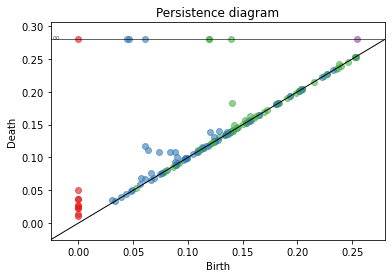

In [33]:
#from importlib import reload  
#sc = reload(sc)
N = 10
points = gen_points(N)
p_filt, simplex_objects = periodic_filtration(points)
dCn, dZn, dBn, dHn, pp_int, pp_cont, pairs_w_reps = PH(p_filt, simplex_objects)

print("Chains:")
print(dCn)
print("\nCycles")
print(dZn)
print("\nBoundaries")
print(dBn)
print("\nBetti numbers")
print(dHn)
gd.plot_persistence_diagram(pp_cont)

# Calculating the evolution $\Lambda_0$

## Auxiliary functions for Lambda_0_evolution()

In [ ]:
def p_vol_3d(matrix_np):
    
    """
    Takes 3x3 numpy array containing 3 column vectors, 
    of which either p = 0, 1, 2 or 3 are linearly independant.
    Returns the p-dimensional volume the column vectors span, as well as the dimension p.
    """
    matrix = sp.Matrix(matrix_np)
    mat_red, pivots = matrix.T.rref()
    mat_red=mat_red.T
    p = len(pivots)
    
    if   p==0:
        det_p = 1
    
    elif p==1:
        det_p = mat_red[:,0].norm()
    
    elif p==2:
        
        """
        !!!
        Take norm of cross product of the two reduced vectors
        !!!
        """
        
    elif p==3:
        det_p = la.det(matrix_np)
        
        
    return abs(det_p), p

## The final Lambda_0_evolution()

In [59]:
def Lambda_0_evolution(p_filt, N, pairs_w_reps):
    """
    Takes naive filtration p_filt, 
    number of original connected components (number of 0-Simplices) N, 
    and list of persistence pairs pairs_w_reps.
    
    Returns numpy array time_list of size (len(p_filt), N, 2, 2),
    where the first index is the integer filtration step,
    the second index is the connected component,
    and the leftover 2x2 matrix is the basis spanning Lambda_0 of this connected component at a given timestep. 
    """
    
    """
    !
    Also rescale the basis of Lambda0 by a, b, c 
    when calclulating the determinant.
    (make sure det of Lambda also uses a, b, c)
    !
    """
        
    # Make list of lists
    # First index gives timestep
    # Second index gives connected component (0 to N-1)
    # This then contains all the vectors contributing to this connected component. 
    from Reduce2IntegerBasis import reduce_spanning_set_2d as rss2
    #rss2 = reload(rss2)

    #time_list = [[[] for j in range(N)] for i in range(len(p_filt))]
    time_list = [[np.zeros((2,2),dtype=np.int32) for j in range(N)] for i in range(len(p_filt))]
    time_list = np.zeros((len(p_filt),N,2,2),dtype=np.int32)
    # We need to calculate the connected components .cc for each pair in pairs_w_reps at each timestep i. 
    # At this point we do not save a list of these connected components for each timestep
    # rather we look at some simplex that forms the cacly of the representative pair and look at its cc. 
    # this way we only have little computational work whenever we need to look this up
    # however, in a case such as here where we want to have this information at any given timestep
    # it might be easier to just calculate the cc's once and save them (?)


    for t in range(len(p_filt)):
        # we are at timestep "t"
        span_set_list = [[] for j in range(N)] # one list for each cc
        for pair in pairs_w_reps:
            # we look at persistence pair "pair"
            if pair.dim == 1 and pair.start_int <= t and pair.end_int > t:
                # if this persistence pair is of dimension 1 (1-homology), 
                # has been born before t and will die after t
                # (i.e. it is alive at time t)
                # then its crossing vector contributes to the crossing vectors 
                # of its connected component at time t
                pair.calc_cc() # calculate the connected component of pair
                cc = pair.cc[t]
                #(time_list[time])[cc].append(pair.return_cv(time))
                new_cv = pair.return_cv(t)
                if abs(la.norm(new_cv))>0.9:
                    # check if new vector is noan-trivial before calling the basis reduction function
                    span_set_list[cc] = rss2(span_set_list[cc],new_cv)

        for comp in range(N):
            for i in range(len(span_set_list[comp])):
                time_list[t][comp][:,i] = span_set_list[comp][i]


    """
    for t in range(N,len(p_filt)):
        print(f"\ntime {t}:")
        for comp in range(N):
            print(f"Component {comp} -- Lambda_0 spanned by: {(time_list[t])[comp]}")

    """
    
    return time_list



## TEST:  Lambda_0_evolution()